# Generación de Nombres de Personas con Redes Neuronales Recurrentes

En este cuaderno de Jupyter, exploraremos cómo crear y entrenar una red neuronal recurrente (RNN) para generar nombres de personas de manera automática. Las RNN son especialmente útiles para secuencias de datos, como texto, debido a su capacidad para mantener un estado interno que les permite capturar información contextual a lo largo de la secuencia.

El cuaderno se divide en las siguientes secciones:

1. Preparación del conjunto de datos
    - Lectura de un conjunto de datos de nombres de personas.
    - Preprocesamiento y definición de vocabulario.
    - Creación de secuencias de entrada y etiquetas de salida para el modelo RNN.
2. Construcción del Modelo RNN
    - Método para la propagación hacia adelante.
    - Método para el computo de gradientes.
    - Método para el muestreo de secuencias.
3. Entrenamiento del Modelo
    - Entrenamiento de la RNN utilizando el conjunto de datos de nombres.
    - Muestreo de nombres al final de cada época de entrenamiento.
    - Grafica de pérdida en función de la época
4. Análisis del tamaño del estado oculto
    - Entrenamiento de diversos modelos con distintos tamaños del estado oculto.
    - Graficar pérdida total en función de la época para todos los modelos.
    - Muestro de nombres con el mejor modelo.

Al final de este cuaderno, tendrás una comprensión sólida de cómo crear y entrenar una RNN para generar texto, específicamente nombres de personas. Además, podrás experimentar con diferentes arquitecturas y configuraciones de RNN para mejorar la calidad de los nombres generados.

## 1. Preparación del conjunto de datos

In [ ]:
import random
import pickle
from typing import List

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
# Lectura del conjunto de datos
with open("nombres.txt", "rt") as f:
    data: List[str] = f.readlines()

# Obtener el vocabulario, esto es, el conjunto de letras únicas en el conjunto de datos
vocabulary = set()
for i in range(len(data)):
    data[i] = data[i].lower()
    for character in data[i]:
        vocabulary.update(character.lower())
vocabulary = sorted(vocabulary)
print(f"len(vocabulary): {len(vocabulary)}")
print(f"vocabulary: {vocabulary}")

# Los diccionarios de caracter a indice y viceversa nos van a ayudar a convertir
# la entrada del modelo a un valor numérico y la salida de este a un símbolo del abecedario.
char_to_index = {c: i for i, c in enumerate(vocabulary)}
index_to_char = {i: c for i, c in enumerate(vocabulary)}
print(f"char_to_index: {char_to_index}")
print(f"index_to_char: {index_to_char}")

len(vocabulary): 27
vocabulary: ['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
char_to_index: {'\n': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
index_to_char: {0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [ ]:
def string_to_indices(string: str) -> torch.LongTensor:
    """Convierte una cadena de caracteres en un tensor índices numéricos.

    :param string: Cadena de caracteres a convertir en índices.
    :return: Tensor de índices de tipo `torch.long` que representa la secuencia de caracteres de entrada.
    """
    indices = []
    for c in string:
        indices.append(char_to_index[c])
    return torch.tensor(indices, dtype=torch.long)


X, Y = [], []
for string in data:
    string = string.strip()  # Retiramos los saltos de línea
    # xt representa una instancia de entrenamiento, es un tensor de dimensiones
    # (len(string) + 1, len(vocabulary)) en donde L representa la longitud de la cadena. El
    # número de filas es len(string) + 1 debido a que tenemos que agregar el vector de ceros
    # como primer input, el número de columnas es de tamaño len(vocabulary) para representar
    # cada letra con un one hot vector.
    xt = torch.zeros(len(string) + 1, len(vocabulary), dtype=torch.float32)
    # Dejamos la primera fila con certos y llenamos el resto con la representación one hot de
    # las letras del nombre a codificar. La función F.one_hot toma como entrada un tensor de
    # índices y devuelve un tensor con la codificación one hot de cada uno estos.
    xt[1:] = F.one_hot(string_to_indices(string), num_classes=len(vocabulary))
    X.append(xt)
    # yt es igual a xt desplazado a la izquierda una posición y sustityendo el vector de ceros
    # con el vector de la representación one hot del símbolo de salto de línea.
    Y.append(torch.concat((xt[1:], F.one_hot(string_to_indices("\n"), num_classes=len(vocabulary))), dim=0))

## 2. Construcción del modelo de RNN

![photo_2023-03-17_00-13-36.jpg](attachment:photo_2023-03-17_00-13-36.jpg)

In [ ]:
class RNN:
    """Una clase que representa una simple red neuronal recurrente (RNN) de una sola capa

    :param nx: Longitud del vector de entrada en cada paso de tiempo.
    :param nh: Longitud del vector que representa el estado oculto de la red.
    :param ny: Longitud del vector de salida en cada paso de tiempo.
    :ivar gradients: Diccionario que contiene los gradientes de la función de costo con respecto
        a los parámetros del modelo.
    :ivar parameters: Diccionario que contiene los parámetros del modelo.
    """
    def __init__(self, nx: int, nh: int, ny: int) -> None:
        self.nx, self.nh, self.ny = nx, nh, ny
        self.gradients = {
            "b": torch.zeros(nh, 1, dtype=torch.float32),
            "c": torch.zeros(ny, 1, dtype=torch.float32),
            "U": torch.zeros(nh, nx, dtype=torch.float32),
            "W": torch.zeros(nh, nh, dtype=torch.float32),
            "V": torch.zeros(ny, nh, dtype=torch.float32),
        }
        # Se inicializan los pesos con una distribución uniforme entre [-0.1, 0.1]
        self.parameters = {
            "b": 0.2 * torch.rand(nh, 1, dtype=torch.float32) - 0.1,
            "c": 0.2 * torch.rand(ny, 1, dtype=torch.float32) - 0.1,
            "U": 0.2 * torch.rand(nh, nx, dtype=torch.float32) - 0.1,
            "W": 0.2 * torch.rand(nh, nh, dtype=torch.float32) - 0.1,
            "V": 0.2 * torch.rand(ny, nh, dtype=torch.float32) - 0.1,
        }

    def forward(self, input: torch.FloatTensor) -> None:
        """Realiza la propagación hacia adelante de la red neuronal para una sola instancia de
        entrenamiento. Guarda las variables necesarias para realizar la retropropagación del error
        en el método compute_gradients.

        :param input: Tensor de dimensiones (L, nx) donde L es el número de unidades de la red, esto
            es, la longitud de la cadena de entrada.
        """
        num_units = input.size()[0]
        # h_prev es una variable auxiliar que contiene el estado oculto de la anterior celda
        h_prev = torch.zeros(self.nh, 1, dtype=torch.float32)
        # Inicializamos variables que van a ser utilizadas en la retropropagación, la variable
        # logits contiene la salida de la red antes de pasar por la función Softmax. El número
        # de filas de hidden_state es num_units + 1 para considerar el vector de ceros que se
        # usa en la entrada de la primera celda
        logits = torch.empty(num_units, self.ny, dtype=torch.float32)
        output = torch.empty(num_units, self.ny, dtype=torch.float32)
        hidden_state = torch.zeros(num_units + 1, self.nh, dtype=torch.float32)
        # Ejecutamos la propagación hacia adelante para cada celda de izquierda a derecha
        for u in range(num_units):
            h = torch.tanh(
                self.parameters["b"]
                + self.parameters["W"] @ h_prev
                + self.parameters["U"] @ input[[u]].T
            )
            hidden_state[u + 1] = h.T
            o = (self.parameters["c"] + self.parameters["V"] @ h).T
            logits[u] = o
            output[u] = F.softmax(o, dim=1)
            h_prev = h

        # Guardar variables para retropropagación
        self.output = output
        self.logits = logits
        self.input = input
        self.hidden_state = hidden_state

    def compute_gradients(self, target: torch.FloatTensor) -> None:
        """Computes the gradients of the loss with respecto to the parameters.
        :param target: Torch tensor of shape (L, ny) represents the ground truth
        """
        self._reset_gradients()  # Reseteamos gradientes de baches pasados
        num_units = target.size()[0]
        # En la fase de retropropagación calculamos los gradientes de derecha a izquierda, h_nex_grad
        # se inicializa con ceros para representar que la última celda de la red no recibe un gradiente
        # del siguiente instante de tiempo. Con respecto a range(num_units - 1, -1, -1), si tenemos
        # cinco celdas, se itera con los valores de u:  [4, 3, 2, 1, 0]
        h_nex_grad = torch.zeros(self.nh, 1, dtype=torch.float32)
        for u in range(num_units - 1, -1, -1):
            if u == num_units - 1:
                # Si estamos en la última celda, no usamos el gradiente de h de la siguiente celda
                h_grad = self.parameters["V"].T @ (self.output[[u]] - target[[u]]).T
            else:
                h_grad = (
                    self.parameters["W"].T
                    @ torch.diag((1 - self.hidden_state[[u + 2]].T ** 2).squeeze())
                ) @ h_nex_grad + (
                    self.parameters["V"].T @ (self.output[[u]] - target[[u]]).T
                )
            self.gradients["c"] += (self.output[[u]] - target[[u]]).T
            self.gradients["b"] += torch.diag(h_grad.squeeze()) @ (
                1 - self.hidden_state[[u + 1]].T ** 2
            )
            self.gradients["U"] += (
                torch.diag(h_grad.squeeze()) @ (1 - self.hidden_state[[u + 1]].T ** 2) @ self.input[[u]]
            )
            self.gradients["W"] += (
                torch.diag(h_grad.squeeze())
                @ (1 - self.hidden_state[[u + 1]].T ** 2)
                @ self.hidden_state[[u]]
            )
            self.gradients["V"] += (self.output[[u]] - target[[u]]).T @ self.hidden_state[[u + 1]]
            h_nex_grad = h_grad

    def compute_loss(self, target: torch.FloatTensor) -> float:
        """Calcula la pérdida de entropía cruzada entre los logits de salida y las etiquetas reales.
        https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html

        :param target: Las etiquetas reales de los datos de entrada.
        :return: La pérdida de entropía cruzada.
        """
        return F.cross_entropy(input=self.logits, target=torch.argmax(target, dim=1), reduction="sum")

    def sample_sequence(self, max_seq_size: int) -> List[int]:
        """Muestre un nombre de manera aleatoria.

        :param max_seq_size: El tamaño máximo del nombre a muestrear.
        :return: Lista de indices representando el nombre muestreado.
        """
        # Se muestrea letra por letra, se utilizan las siguientes variables:
        # index: Índice actual muestreado, si se muestrea \n la función regresa el nombre obtenido
        # count: Número de letras muestreadas, se lleva registro de esto ya que si muestremos más de
        #     max_seq_size terminamos el muestreo.
        # indices: Lista de todos los índices (letras) muestreados, es el valor que regresa la función.
        # h_prev: Para hacer el muestreo tenemos que hacer la propagación hacia adelante, esta variable
        #     contiene el valor del estado oculto de la unidad anterior
        # xt: Representa la entrada del modelo para algún instante de tiempo.
        index = None
        count = 0
        indices = []
        h_prev = torch.zeros(self.nh, 1, dtype=torch.float32)
        xt = torch.zeros(1, self.nx, dtype=torch.float32)
        while count < max_seq_size and index != 0:
            # Propagación hacia adelante
            h = torch.tanh(
                self.parameters["b"]
                + self.parameters["W"] @ h_prev
                + self.parameters["U"] @ xt.T
            )
            o = (self.parameters["c"] + self.parameters["V"] @ h).T
            y = F.softmax(o.double(), dim=1)
            # np.random.choice(self.ny, p=y.ravel()) selecciona un valor entre 0 y self.ny en donde la
            # probabilidad de elegir cada elemento se define con el parámetro p.
            index = np.random.choice(self.ny, p=y.ravel())
            h_prev = h
            xt[:] = 0
            xt[0][index] = 1
            indices.append(index)
            count += 1
        return indices

    def _reset_gradients(self) -> None:
        """Resetea (igualar a cero) los gradientes para todos los parámetros."""
        for k in self.gradients.keys():
            self.gradients[k][:] = 0

## 3. Entrenamiento del Modelo

In [ ]:
# Model definition
model = RNN(nx=len(vocabulary), nh=32, ny=len(vocabulary))

# Hyperparameters
epochs = 500
learning_rate = 0.001
loss_history = []  # Contiene el historial de pérdidas en cada época
# Training loop
for e in range(epochs):
    total_loss = 0  # Contiene la pérdida total de la época
    for input, target in zip(X, Y):  # Stochastic gradient descent
        model.forward(input)
        model.compute_gradients(target)
        loss = model.compute_loss(target)
        total_loss += loss
        # Actualizamos los pesos del modelo con el algoritmo del descenso del gradiente
        for k, v in model.gradients.items():
            model.parameters[k] -= learning_rate * model.gradients[k]
    loss_history.append(total_loss.item() / len(data))
    # Muestreamos un nombre con el modelo actual
    indices = model.sample_sequence(max_seq_size=15)
    characters = [index_to_char[i] for i in indices]
    sample = "".join(characters).strip()
    print(f'epoch: {e + 1}/{epochs}, loss: {total_loss / len(data)}, sample: {sample}')

epoch: 1/500, loss: 21.404176712036133, sample: mpmjemetxerijv
epoch: 2/500, loss: 19.48058319091797, sample: a
epoch: 3/500, loss: 19.05818748474121, sample: trsyoen
epoch: 4/500, loss: 18.628482818603516, sample: oavie
epoch: 5/500, loss: 18.370595932006836, sample: ril
epoch: 6/500, loss: 18.22474479675293, sample: nllun
epoch: 7/500, loss: 18.07640838623047, sample: ioanm
epoch: 8/500, loss: 17.89616584777832, sample: afeney
epoch: 9/500, loss: 17.685720443725586, sample: baodh
epoch: 10/500, loss: 17.46761703491211, sample: abnae
epoch: 11/500, loss: 17.2676944732666, sample: sasaxau
epoch: 12/500, loss: 17.096317291259766, sample: oaiaf
epoch: 13/500, loss: 16.949810028076172, sample: elaog
epoch: 14/500, loss: 16.821613311767578, sample: janten
epoch: 15/500, loss: 16.707651138305664, sample: oefj
epoch: 16/500, loss: 16.60556411743164, sample: sardot
epoch: 17/500, loss: 16.51353645324707, sample: jinbuir
epoch: 18/500, loss: 16.429899215698242, sample: ereses
epoch: 19/500, lo

epoch: 148/500, loss: 13.077985763549805, sample: hibre
epoch: 149/500, loss: 13.0650053024292, sample: curden
epoch: 150/500, loss: 13.052168846130371, sample: felio
epoch: 151/500, loss: 13.039464950561523, sample: joving
epoch: 152/500, loss: 13.026880264282227, sample: zakatr
epoch: 153/500, loss: 13.014439582824707, sample: elediamco
epoch: 154/500, loss: 13.002092361450195, sample: girmon
epoch: 155/500, loss: 12.98987102508545, sample: harelel
epoch: 156/500, loss: 12.977770805358887, sample: mabal
epoch: 157/500, loss: 12.965754508972168, sample: azre
epoch: 158/500, loss: 12.953878402709961, sample: wilsafy
epoch: 159/500, loss: 12.942070007324219, sample: inncro
epoch: 160/500, loss: 12.930380821228027, sample: artin
epoch: 161/500, loss: 12.918773651123047, sample: nrcias
epoch: 162/500, loss: 12.907283782958984, sample: jeseuvi
epoch: 163/500, loss: 12.895867347717285, sample: alejaic
epoch: 164/500, loss: 12.884546279907227, sample: dibrinmo
epoch: 165/500, loss: 12.873287

epoch: 292/500, loss: 11.947183609008789, sample: cariss
epoch: 293/500, loss: 11.930685997009277, sample: astono
epoch: 294/500, loss: 11.914938926696777, sample: jaho
epoch: 295/500, loss: 11.910240173339844, sample: wiltciel
epoch: 296/500, loss: 11.907849311828613, sample: nais
epoch: 297/500, loss: 11.897801399230957, sample: alderom
epoch: 298/500, loss: 11.903877258300781, sample: asselb
epoch: 299/500, loss: 11.900102615356445, sample: ainon
epoch: 300/500, loss: 11.899813652038574, sample: hatlios
epoch: 301/500, loss: 11.89380931854248, sample: mardor
epoch: 302/500, loss: 11.89808464050293, sample: cieleldo
epoch: 303/500, loss: 11.897612571716309, sample: yosvia
epoch: 304/500, loss: 11.919382095336914, sample: adan
epoch: 305/500, loss: 11.889595985412598, sample: kilesm
epoch: 306/500, loss: 11.949792861938477, sample: gredwin
epoch: 307/500, loss: 11.89822769165039, sample: osuad
epoch: 308/500, loss: 11.8781099319458, sample: bentian
epoch: 309/500, loss: 11.86602973937

epoch: 437/500, loss: 11.64033031463623, sample: rado
epoch: 438/500, loss: 11.89163589477539, sample: jeonaro
epoch: 439/500, loss: 11.814656257629395, sample: duisio
epoch: 440/500, loss: 11.62060546875, sample: abmin
epoch: 441/500, loss: 11.610482215881348, sample: adam
epoch: 442/500, loss: 11.628463745117188, sample: aio
epoch: 443/500, loss: 11.568802833557129, sample: etian
epoch: 444/500, loss: 11.607297897338867, sample: gardimo
epoch: 445/500, loss: 11.563712120056152, sample: ferihe
epoch: 446/500, loss: 11.618851661682129, sample: rimeron
epoch: 447/500, loss: 11.773179054260254, sample: amberg
epoch: 448/500, loss: 11.727657318115234, sample: elitho
epoch: 449/500, loss: 11.754124641418457, sample: edceret
epoch: 450/500, loss: 11.695682525634766, sample: kyrirgo
epoch: 451/500, loss: 11.609911918640137, sample: braziel
epoch: 452/500, loss: 11.565629959106445, sample: yahiel
epoch: 453/500, loss: 11.588068008422852, sample: abisay
epoch: 454/500, loss: 11.621723175048828

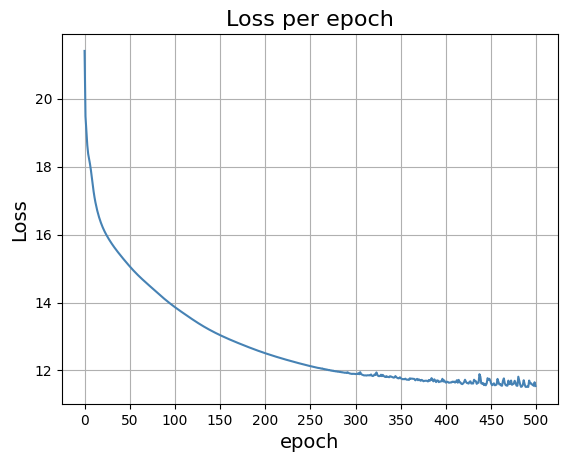

In [ ]:
# Graficar la perdida total por epoca
plt.plot(loss_history, color='steelblue')
plt.xticks(np.arange(0, len(loss_history) + 1, 50))
plt.title("Average loss per epoch", fontsize=16)
plt.xlabel("epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.show()

## 4. Análisis del tamaño del estado oculto

In [ ]:
# hidden_states_sizes = [8, 16, 32, 64, 128, 256]
# hidden_states_loss_histories = []
# for nh in hidden_states_sizes:
#     print(f"Training model with nh={nh}...")
#     model = RNN(nx=len(vocabulary), nh=nh, ny=len(vocabulary))
#     epochs = 500
#     learning_rate = 0.001
#     loss_history = []
#     for e in range(epochs):
#         total_loss = 0
#         for input, target in zip(X, Y):
#             model.forward(input)
#             model.compute_gradients(target)
#             loss = model.compute_loss(target)
#             total_loss += loss
#             for k, v in model.gradients.items():
#                 model.parameters[k] -= learning_rate * model.gradients[k]
#         loss_history.append(total_loss.item() / len(data))
#         indices = model.sample_sequence(max_seq_size=15)
#         characters = [index_to_char[i] for i in indices]
#         sample = "".join(characters).strip()
#     hidden_states_loss_histories.append(loss_history)

In [ ]:
# La celda anterior puede tomar un par de horas en ejecutarse, por lo tanto, cagamos los resultados desde
# cache para analizar los modelos y hacer un muestreo de nombres del mejor de estos.


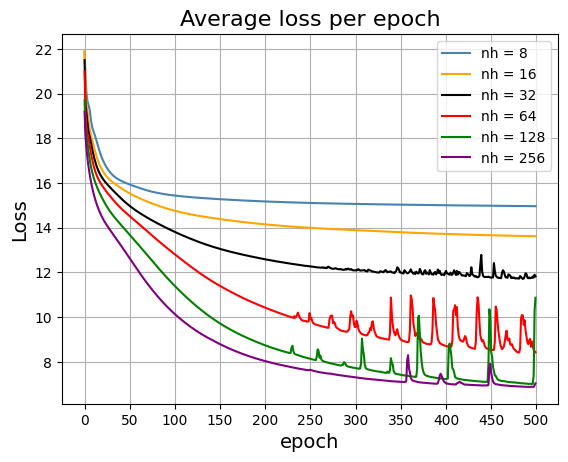

In [ ]:
with open("hidden_states_loss_histories.pkl", 'rb') as file:
    hidden_states_loss_histories = pickle.load(file)

# Graficar la perdida total por epoca
plt.plot(hidden_states_loss_histories[0], color='steelblue', label="nh = 8")
plt.plot(hidden_states_loss_histories[1], color='orange', label="nh = 16")
plt.plot(hidden_states_loss_histories[2], color='black', label="nh = 32")
plt.plot(hidden_states_loss_histories[3], color='red', label="nh = 64")
plt.plot(hidden_states_loss_histories[4], color='green', label="nh = 128")
plt.plot(hidden_states_loss_histories[5], color='purple', label="nh = 256")
plt.xticks(np.arange(0, len(hidden_states_loss_histories[0]) + 1, 50))
plt.title("Average loss per epoch", fontsize=16)
plt.xlabel("epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(loc='best')
plt.grid(True)
plt.show()

Un tamaño de estado oculto menor reduce la capacidad del modelo y puede limitar su capacidad para aprender patrones complejos de los datos; sin embargo, también puede hacer que el modelo sea más resistente al ruido introducido por SGD, ya que el menor número de parámetros podría ser más fácil de optimizar con actualizaciones de gradiente ruidosas.

In [ ]:
# Cargar modelo con nh = 256
with open("model_256_params.pkl", 'rb') as file:
    model_256_params = pickle.load(file)
model = RNN(nx=len(vocabulary), nh=256, ny=len(vocabulary))
model.parameters = model_256_params

# Muestrear 20 nombres con modelo nh=256
samples = []
for _ in range(20):
    indices = model.sample_sequence(max_seq_size=15)
    characters = [index_to_char[i] for i in indices]
    sample = "".join(characters).strip()
    samples.append(sample)
print(f"samples: {samples}")

samples: ['jose', 'levy', 'petra', 'asmin', 'itan', 'wilhelm', 'kenjrick', 'michael', 'zadir', 'iorain', 'fortino', 'joahan', 'elih', 'enoc', 'esaul', 'j', 'raphael', 'johnatan', 'giovanny', 'hebert']
